# Samsung Multicam Pytorch Example
본 과제에서는 pytorch를 이용하여 분류기 모델을 설계하고, CIFAR10 데이터셋에 대하여 학습 및 테스트 코드를 작성할 예정입니다. 

------------------
## 데이터셋

데이터셋을 다루기 위해서는 numpy array로 특정 데이터를 load해야 하고, 이후 pytorch로 연산 가능한 ``torch.*Tensor`` 로 변환해 주어야 합니다.

- 이미지 : Pillow, OpenCV 패키지 사용
- 오디오(스피치) : scipy, librosa 패키지 사용

추가적으로 컴퓨터 비전 데이터를 다룰 때 ``torchvision``이라는 패키지를 사용하면 유용하고, 여러 데이터셋들을 다운 받을 수 있습니다. 

**본 과제에서는 데이터셋으로 CIFAR10을 사용할 예정입니다.**

CIFAR10은 3x32x32 크기의 이미지로 총 10개의 클래스(‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’) 로 구성된 6000장의 데이터셋입니다. 

------------------
## 이미지 분류기 학습시키기
본 과제는 아래의 순서로 진행됩니다.

1. **데이터셋 준비 및 전처리** : ``torchvision``을 사용하여 CIFAR10 training, test 데이터셋을 load하고 normalize
2. **분류기 모델 설계** : CNN을 사용하여 분류기 모델 설계
3. **Loss function 정의** : 학습 시 사용되는 loss function 정의하기
4. **모델 학습하기** : 1.의 training 데이터셋으로 설정한 epoch만큼 모델을 학습
5. **테스트하기** : 학습이 완료된 모델을 1.의 test 데이터셋으로 테스트하기


모든 데이터셋이 ``torchvision``으로 다운 받을 수 있는 것은 아니지만, CIFAR10은 torchvision으로 손쉽게 다운받을 수 있습니다.



**torch**는 pytorch의 가장 상위에 있는 package로써 라이브러리에서 이것저것 불러오기 위해 import

**torchvision**은 Computer vision에서 사용하는 각종 테크닉들을 torch와 연동하여 구현한 라이브러리

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## 1. 데이터셋 준비 및 전처리
- ``torchvision``을 사용하여 CIFAR10 을 load 할 수 있습니다.
- ``torchvision.transform`` 을 사용하여 데이터를 normalize할 수 있습니다.

**references**\
dataloader(pytorch doc)\
https://pytorch.org/docs/stable/data.html

dataloader parameter(blog)\
https://subinium.github.io/pytorch-dataloader/


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 데이터 시각화
- ``matplotlib``는 python visualization library
- ``matplotlib``의 imshow 함수를 데이터들을 시각화 할 수 있습니다.


**references**

matplotlib doc\
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html


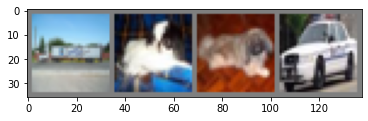

truck   dog   dog   car


In [3]:
# Req. 1-1	데이터셋 준비 및 전처리
# 이미지를 시각화하는 함수
def visualize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

# 트레이닝 데이터를 랜덤 샘플
dataiter = iter(trainloader)
images, labels = dataiter.next() ## image

# show images
visualize(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. 분류기 모델 설계
- CNN (Convolutional Neural Network)를 사용하여 모델 설계합니다.
- 이미지는 3-channel을 입력으로 받고, 최종적으로 10개의 class에 대한 확률을 구합니다.
- 아래의 모델을 예시이므로, layer를 직접 추가해보면서 실험하시길 바랍니다.

### Classifier 클래스
- nn.Module: 뉴럴넷 구현을 위한 base class. forward, parameter 등 모델을 만들고 사용할 때 필요한 부분들이 내부적으로 구현되어 있음.
- torch.nn은 모델을 정의할 때 사용하는 Class들을 포함하고 있음.

- init: python class의 constructor. 필요한 멤버변수들을 초기화하고, nn.Sequential or nn.ModuleList를 이용하여 모델의 구성을 정의한다.

- forward: 모델의 input을 받고 output을 return하는 함수.

### Pytorch functions
- ``nn.Conv2d`` : torch.nn.Conv2d(in_channels: int, out_channels: int, kernel_size, stride = 1, padding = 0)
- ``nn.Maxpool2d`` : torch.nn.MaxPool2d(kernel_size, stride = None, padding = 0)
- ``nn.Linear`` : torch.nn.Linear(in_features: int, out_features: int, bias: bool = True)


**references**

https://tutorials.pytorch.kr/beginner/examples_nn/two_layer_net_module.html

https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html


**tips**

http://taewan.kim/post/cnn/

http://taewan.kim/post/cnn/#4-cnn-%EC%9E%85%EC%B6%9C%EB%A0%A5-%ED%8C%8C%EB%A6%AC%EB%AF%B8%ED%84%B0-%EA%B3%84%EC%82%B0

https://mrsyee.github.io/image%20processing/2018/11/28/cnn_technique/


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Req. 1-2	분류기 모델 설계
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

classifier = Classifier()

## 3. Loss function 정의
- 분류기를 위해서 cross-entropy loss를 사용합니다.
- optimzer로 SGD를 사용하고, learning rate, momentum등을 설정해줍니다.

### Pytorch functions
- ``nn.CrossEntropyLoss`` : torch.nn.CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None)
- ``optim.SGD`` :torch.optim.SGD(params, lr=<required parameter>, momentum=0)

**references**

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

https://pytorch.org/docs/stable/optim.html

**tips**

https://forensics.tistory.com/28

https://wordbe.tistory.com/entry/ML-Cross-entropyCategorical-Binary%EC%9D%98-%EC%9D%B4%ED%95%B4

https://gomguard.tistory.com/187


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)



## 4. 모델 학습시키기
1) **첫번째 for문**으로 epochs 만큼 반복

2) **두번째 for문**으로 trainset이 저장되어 있는 **trainloader**에서 배치 사이즈 만큼씩 샘플링하여 data load

3) load한 data에서 input 값과 label로 분리하여 저장

4) 각각의 값을 device에 올린다 (GPU or CPU)

5) optimizer에서 gradient 값 0으로 초기화

6) model에 input값을 입력하여 forward propagation

7) loss function으로 예측값과 label 비교

8) loss 값 backpropagation 하여 gradient 계산

9) 계산된 gradient를 모두 parameter에 적용

10) loss 값을 합하여 일정 주기(ex.2000 batch) 마다 평균 loss 값 출력 후 초기화

11) 2)로 돌아가 반복 한뒤 2)가 모두 마치면 1)로 돌아가 반복

12) 학습이 마친 이후 모델 저장

### Pytorch functions
- ``nn.CrossEntropyLoss`` : torch.nn.CrossEntropyLoss(weight: Optional[torch.Tensor] = None, size_average=None)
- ``optim.SGD`` :torch.optim.SGD(params, lr=<required parameter>, momentum=0)

**references**

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

https://pytorch.org/docs/stable/optim.html

https://tutorials.pytorch.kr/beginner/saving_loading_models.html

**tips**

https://forensics.tistory.com/28

https://wordbe.tistory.com/entry/ML-Cross-entropyCategorical-Binary%EC%9D%98-%EC%9D%B4%ED%95%B4

https://gomguard.tistory.com/187


### GPU 
GPU가 있다면 GPU를 통해 학습을 가속화하고, 없으면 CPU로 학습하기 위해 device를 정해줍니다.


In [6]:
# Req. 1-4	모델 학습
# model을 device에 올린다 (GPU or CPU) 
# 구현 완료 상태
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = classifier.to(device)

In [7]:
# Req. 1-4	모델 학습
epochs = 5  #define epochs

# 1) for문으로 epochs 만큼 반복
for epoch in range(epochs):  # epochs 횟수만큼 반복
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.228
[1,  4000] loss: 1.902
[1,  6000] loss: 1.661
[1,  8000] loss: 1.568
[1, 10000] loss: 1.524
[1, 12000] loss: 1.478
[2,  2000] loss: 1.398
[2,  4000] loss: 1.377
[2,  6000] loss: 1.363
[2,  8000] loss: 1.314
[2, 10000] loss: 1.319
[2, 12000] loss: 1.279
[3,  2000] loss: 1.217
[3,  4000] loss: 1.213
[3,  6000] loss: 1.201
[3,  8000] loss: 1.211
[3, 10000] loss: 1.188
[3, 12000] loss: 1.193
[4,  2000] loss: 1.103
[4,  4000] loss: 1.110
[4,  6000] loss: 1.104
[4,  8000] loss: 1.131
[4, 10000] loss: 1.123
[4, 12000] loss: 1.102
[5,  2000] loss: 1.020
[5,  4000] loss: 1.069
[5,  6000] loss: 1.058
[5,  8000] loss: 1.076
[5, 10000] loss: 1.064
[5, 12000] loss: 1.048
Finished Training


## 5. 테스트하기 
- 학습이 완료된 모델을 testset이 저장되어 있는 **testloader**에 대하여 성능 평가
- 모델을 evaluation 모드로 변경
- gradient계산 할 필요가 없고, backpropagation도 진행하지 않는다.

### 진행 방식
만약 저장한 모델을 load해야 한다면, 모델의 인스턴스를 생성하고, 모델의 weight이 저장되어 있는 .ckpt 파일을 모델에 load

1) 모델을 evaluation 모드로 전환

2) with torch.no_grad로 gradient 계산을 제외

3) for문으로 testset에 저장되어 있는 testloader에서 배치 사이즈 만큼씩 샘플링하여 data load

4) load한 data에서 input 값과 label로 분리하여 저장

5) 각각의 값을 device에 올린다 (GPU or CPU)

6) model에 input값을 입력하여 forward propagation

7) 예측한 값들 중 가장 높은 확률의 class 선택

8) label과 예측한 class 비교하여 정답 확인

9) 정답률 출력

### Pytorch functions
- ``torch.no_grad`` : gradient를 계산하기 위해 추적하는 수고를 하지 않음



In [8]:
#저장
PATH = './cifar_classifier.pth'
torch.save(classifier.state_dict(), PATH)


In [10]:
# Req. 1-5	모델 테스트
# 만약 저장한 모델을 load해야 한다면, 모델의 인스턴스를 생성하고, 모델의 weight이 저장되어 있는 .ckpt 파일을 모델에 load
new_classifier = Classifier()
new_classifier.load_state_dict(torch.load(PATH))
new_classifier.to(device)

# 1) 모델을 evaluation 모드로 전환
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = new_classifier(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

# 9) 정답률 출력

Accuracy of the network on the 10000 test images: 60 %
